In [1]:
import scanpy.api as sc
import pandas as pd

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

Same stuff, this time around Harmony.

In [3]:
adata = sc.read('objects-pancreas/pancreas_bbknn.h5ad')
pca = adata.obsm['X_pca']
batch = adata.obs['sample']

In [4]:
%load_ext rpy2.ipython

Takes 1.8 minutes. Needed a fiddle with theta to work.

In [5]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

t1 = Sys.time()
hem <- HarmonyMatrix(pca, batch, theta=4)
t2 = Sys.time()

hem = data.frame(hem)

t2-t1

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Harmony 1/10

  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 0%   10   20   30   40   50   60   70   80   90   100%

  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: [----|----|----|----|----|----|----|----|----|----|

  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: *
  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: |

  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Harmony 2/10

  warnings.warn(x, RRunt

Clustered for 119 iterations
Clustered for 116 iterations
Clustered for 101 iterations
Clustered for 101 iterations
Clustered for 99 iterations
Clustered for 106 iterations
Clustered for 112 iterations
Time difference of 1.807161 mins


While this may be a BBKNN demonstration GitHub/notebook, I have to admit that's beautiful merging. But it's still notably slower than BBKNN, as captured in the benchmark.

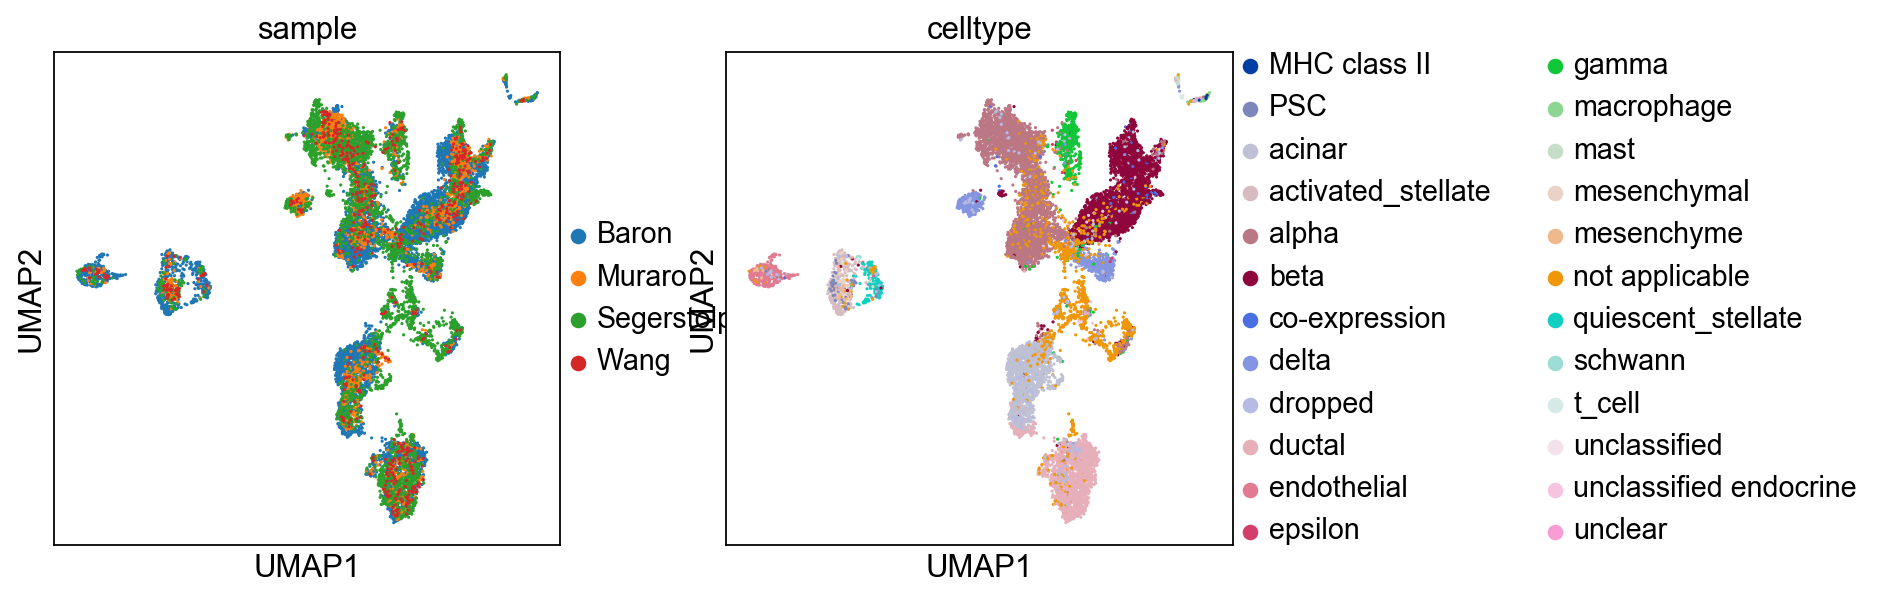

In [6]:
adata.obsm['X_pca'] = hem.values
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample','celltype'])
adata.write('objects-pancreas/pancreas_harmony.h5ad')

Seeing how we ran a number of methods, let's formally assess how well they did this whole "remove batch effect" thing via kBET. We have to run it on UMAP space, as that's where the methods meet - not everything corrects the count matrix, and BBKNN doesn't even fix the dimensionality reduction space. Seeing how this is dimensionality reduced already, no need to run PCA on it, so tell kBET about that.

In [7]:
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

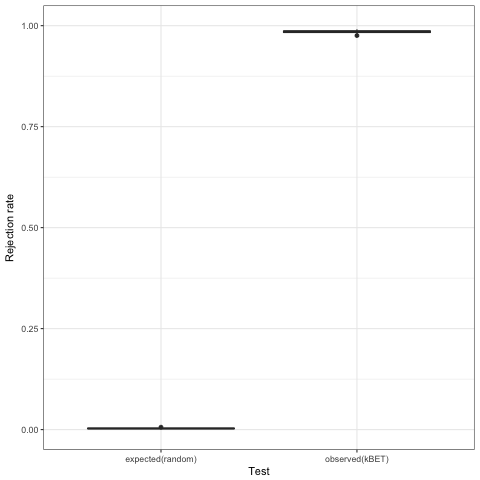

In [8]:
%%R -i umap -i batch -o vals

library(kBET)

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [9]:
harmony_ci = vals
vals

0.978554,0.985714,0.990153


In [10]:
adata = sc.read('objects-pancreas/pancreas_bbknn_trim.h5ad')
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

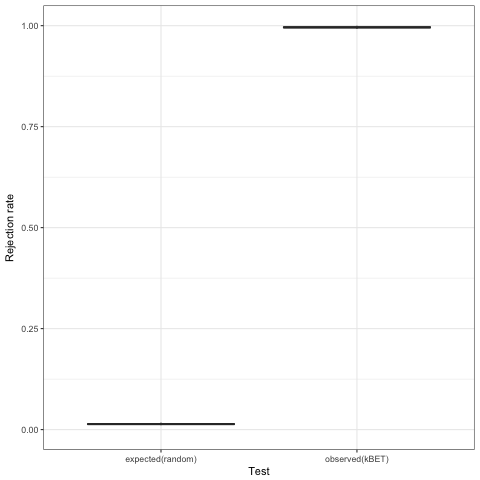

In [11]:
%%R -i umap -i batch -o vals

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [12]:
bbknn_ci = vals
vals

0.992840,0.995918,0.999320


In [13]:
adata = sc.read('objects-pancreas/pancreas_mnncorrect.h5ad')
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

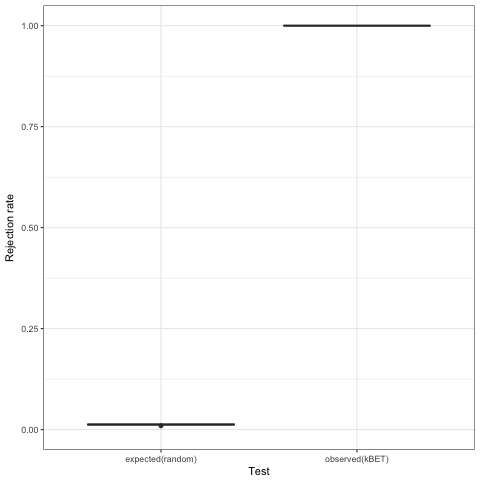

In [14]:
%%R -i umap -i batch -o vals

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [15]:
mnn_ci = vals
vals

1.000000,1.000000,1.000000


In [16]:
adata = sc.read('objects-pancreas/pancreas.h5ad')
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

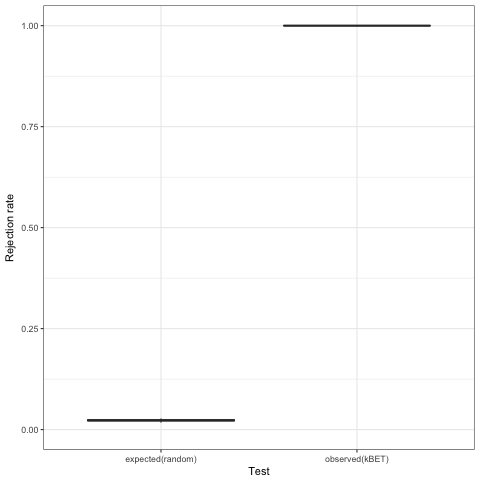

In [17]:
%%R -i umap -i batch -o vals

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [18]:
raw_ci = vals
vals

1.000000,1.000000,1.000000


In [19]:
adata = sc.read('objects-pancreas/pancreas_cca.h5ad')
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

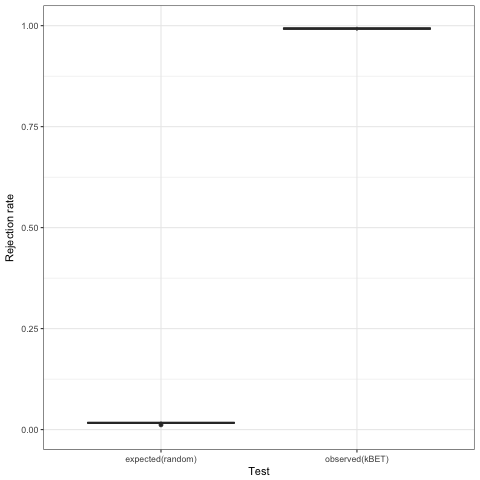

In [20]:
%%R -i umap -i batch -o vals

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [21]:
cca_ci = vals
vals

0.987755,0.992857,0.996599


In [22]:
adata = sc.read('objects-pancreas/pancreas_scanorama.h5ad')
umap = adata.obsm['X_umap']
batch = adata.obs['sample']

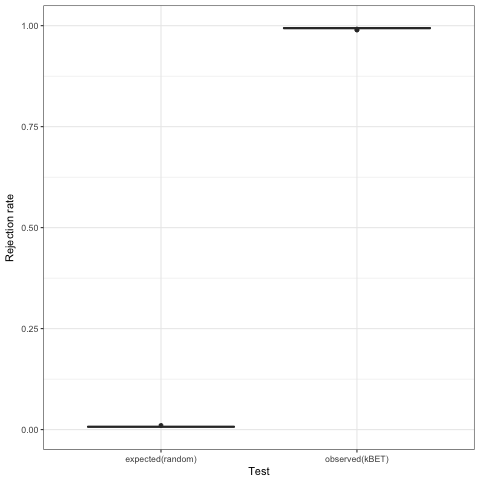

In [23]:
%%R -i umap -i batch -o vals

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

In [24]:
scanorama_ci = vals
vals

0.990223,0.993715,0.997207


Shuffle the values we just got out of this into a `plt.errorbar()` compatible form.

In [25]:
x = np.arange(6)

In [26]:
y = [raw_ci[1],bbknn_ci[1],mnn_ci[1],cca_ci[1],scanorama_ci[1],harmony_ci[1]]

In [27]:
yerr = np.zeros((2,6))

In [28]:
which = raw_ci
i=0

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

In [29]:
which = bbknn_ci
i=1

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

In [30]:
which = mnn_ci
i=2

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

In [31]:
which = cca_ci
i=3

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

In [32]:
which = scanorama_ci
i=4

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

In [33]:
which = harmony_ci
i=5

yerr[0,i] = which[1]-which[0]
yerr[1,i] = which[2]-which[1]

Collate this info into a single plot, while also adding run times captured in these notebooks. The plot matches what can be intuitively seen in the UMAPs' sample distributions, but formally quantifies it.

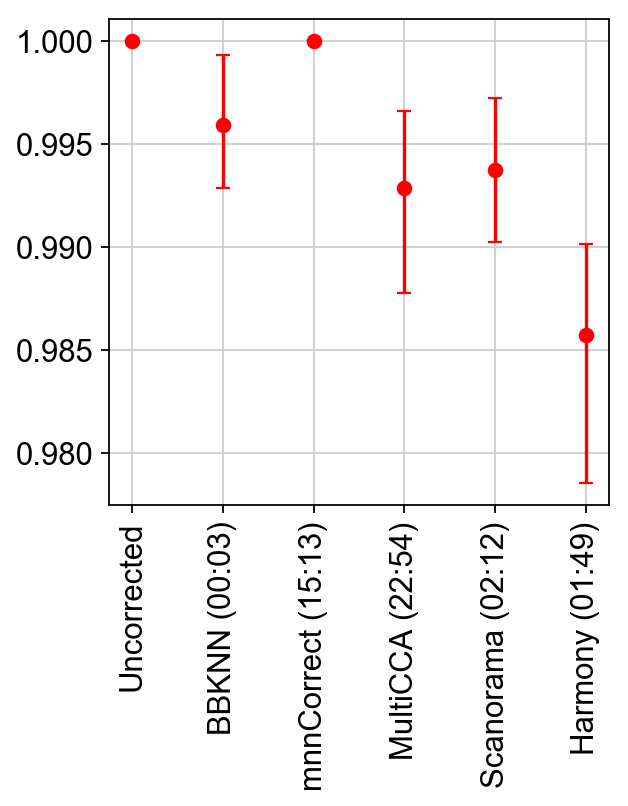

In [34]:
plt.errorbar(x,y,yerr,fmt='ro',capsize=3)
plt.xticks(np.arange(6),['Uncorrected','BBKNN (00:03)',
                         'mnnCorrect (15:13)','MultiCCA (22:54)',
                         'Scanorama (02:12)','Harmony (01:49)'], rotation='vertical')
plt.show()